In [ ]:
#Imports
# !pip install stop_words
import requests
import numpy as np
import pandas as pd
import json
import glob

from google.colab import drive

import tensorflow as tf
from tensorflow import keras

# This will prompt for authorization./
drive.mount('/content/drive')
# !ls "/content/drive/My Drive/Colab Notebooks"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
cleaned_content = pd.read_csv("/content/drive/My Drive/Colab Notebooks (1)/PeerReadDataset/cleaned_data/preprocessed_final_data.csv")
cleaned_content.head(2)

,APPROPRIATENESS,Abstract,Accepted,CLARITY,Conclusion,Content,Discussion,IMPACT,Introduction,MEANINGFUL_COMPARISON,Name,ORIGINALITY,PRESENTATION_FORMAT,RECOMMENDATION,REPLICABILITY,REVIEWER_CONFIDENCE,Related_work,Result,SOUNDNESS_CORRECTNESS,SUBSTANCE,Title,Year,comments,is_meta_review,terms
0,5,We propose two novel methodologies for the aut...,1.0,4,"Our contributions are twofold. First, we devel...",Our first model is a pure neural language mode...,NaN,3.0,Poetry is an advanced form of linguistic commu...,5.0,660,4,Oral Presentation,4,NaN,3,Automatic poetry generation is an important ta...,In order to examine how effective our methodol...,3,5,Automatically Generating Rhythmic Verse with N...,2017.0,The paper presents two approaches for generati...,NaN,the paper present two approach for generating ...
1,5,We propose two novel methodologies for the aut...,1.0,3,"Our contributions are twofold. First, we devel...",Our first model is a pure neural language mode...,NaN,3.0,Poetry is an advanced form of linguistic commu...,5.0,660,4,Poster,3,NaN,4,Automatic poetry generation is an important ta...,In order to examine how effective our methodol...,3,4,Automatically Generating Rhythmic Verse with N...,2017.0,The paper describes two methodologies for the ...,NaN,the paper describes two methodology for the au...


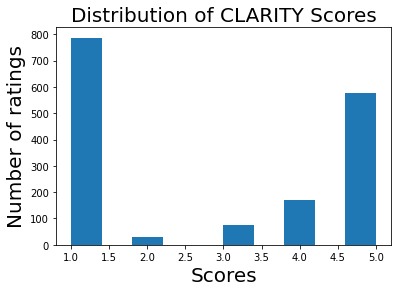

In [ ]:
import matplotlib.pyplot as plt
def score_plot():
  plt.figure(figsize=(6,4))
  plt.hist(x=cleaned_content['CLARITY'])

  # Add title and axis names
  plt.title('Distribution of CLARITY Scores', fontsize=20)
  plt.ylabel('Number of ratings', fontsize=20)
  plt.xlabel('Scores', fontsize=20)

  plt.show()

score_plot()

In [ ]:
from keras.preprocessing.text import Tokenizer
# The maximum number of words to be used. (most frequent)
MAX_NB_WORDS = 10000
# Max number of words in each complaint.
MAX_SEQUENCE_LENGTH = 500
# This is fixed.
EMBEDDING_DIM = 100
tokenizer = Tokenizer(num_words=MAX_NB_WORDS, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(cleaned_content['terms'])
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 16008 unique tokens.


In [ ]:
from keras.preprocessing.sequence import pad_sequences
X = tokenizer.texts_to_sequences(cleaned_content['terms'].values)
X = pad_sequences(X, maxlen=MAX_SEQUENCE_LENGTH)
print('Shape of data tensor:', X.shape)

Shape of data tensor: (1635, 500)


In [ ]:
Y = pd.get_dummies(cleaned_content['CLARITY']).values
print('Shape of label tensor:', Y.shape)

Shape of label tensor: (1635, 5)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size = 0.20, random_state = 42)
print(X_train.shape,Y_train.shape)
print(X_test.shape,Y_test.shape)

(1308, 500) (1308, 5)
(327, 500) (327, 5)


In [ ]:
x_train = X_train[:50]
y_train = Y_train[:50]
x = X_test[:277]
y = Y_test[:277]

x_test = np.concatenate((x,x_train))
y_test = np.concatenate((y, y_train))
print(x_test.shape,y_test.shape)

(327, 500) (327, 5)


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=X.shape[1]))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(5, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
print(model.summary())

Model: "sequential_21"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_21 (Embedding)     (None, 500, 100)          1000000   
_________________________________________________________________
spatial_dropout1d_21 (Spatia (None, 500, 100)          0         
_________________________________________________________________
lstm_27 (LSTM)               (None, 100)               80400     
_________________________________________________________________
dense_17 (Dense)             (None, 5)                 505       
Total params: 1,080,905
Trainable params: 1,080,905
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
epochs = 10
batch_size = 64

history = model.fit(X_train, Y_train, epochs=epochs, batch_size=batch_size)

Epoch 1/10
21/21 [==============================] - 30s 1s/step - loss: 1.5150 - accuracy: 0.3671
Epoch 2/10
21/21 [==============================] - 27s 1s/step - loss: 1.1706 - accuracy: 0.4965
Epoch 3/10
21/21 [==============================] - 27s 1s/step - loss: 1.1400 - accuracy: 0.5093
Epoch 4/10
21/21 [==============================] - 26s 1s/step - loss: 1.0373 - accuracy: 0.4930
Epoch 5/10
21/21 [==============================] - 26s 1s/step - loss: 0.8373 - accuracy: 0.6491
Epoch 6/10
21/21 [==============================] - 27s 1s/step - loss: 0.5831 - accuracy: 0.7662
Epoch 7/10
21/21 [==============================] - 27s 1s/step - loss: 0.5303 - accuracy: 0.8221
Epoch 8/10
21/21 [==============================] - 27s 1s/step - loss: 0.3222 - accuracy: 0.8997
Epoch 9/10
21/21 [==============================] - 26s 1s/step - loss: 0.2872 - accuracy: 0.9001
Epoch 10/10
21/21 [==============================] - 27s 1s/step - loss: 0.1908 - accuracy: 0.9546


In [ ]:
accr = model.evaluate(x_test,y_test)
print('Test set\n  Loss: {:0.3f}\n  Accuracy: {:0.3f}'.format(accr[0],accr[1]))

11/11 [==============================] - 1s 117ms/step - loss: 1.7776 - accuracy: 0.5994
Test set
  Loss: 1.778
  Accuracy: 0.599


In [ ]:
from sklearn import metrics
from numpy import argmax
predicted = model.predict(x_test).tolist()
pred = []
val = []
for values in predicted:
    pred.append(values.index(max(values)))
for values in y_test:
    val.append(argmax(values))
print(metrics.classification_report(val, pred))

              precision    recall  f1-score   support

           0       0.62      0.78      0.69       152
           1       0.00      0.00      0.00         5
           2       0.33      0.15      0.21        13
           3       0.52      0.30      0.38        40
           4       0.59      0.55      0.57       117

    accuracy                           0.60       327
   macro avg       0.41      0.36      0.37       327
weighted avg       0.58      0.60      0.58       327



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [ ]:
new_review = ['The paper is overall well-written and easy to follow.']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['1','2','3','4','5']
print(pred, labels[np.argmax(pred)])

[[2.8393448e-03 1.8690513e-04 9.0412027e-04 1.9364654e-03 9.9413317e-01]] 5


In [ ]:
new_review = ['It is not clear to me how the presented approach works.']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['1','2','3','4','5']
print(pred, labels[np.argmax(pred)])

[[0.7901854  0.00384257 0.00471822 0.00494774 0.19630605]] 1


In [ ]:
new_review = ['It’s not clear what makes this algorithm interesting for this use-case.']
seq = tokenizer.texts_to_sequences(new_review)
padded = pad_sequences(seq, maxlen=MAX_SEQUENCE_LENGTH)
pred = model.predict(padded)
labels = ['1','2','3','4','5']
print(pred, labels[np.argmax(pred)])

[[0.07765456 0.00164152 0.00420903 0.00411574 0.91237915]] 5


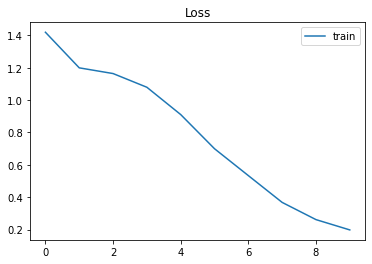

In [ ]:
plt.title('Loss')
plt.plot(history.history['loss'], label='train')
plt.legend()
plt.show();

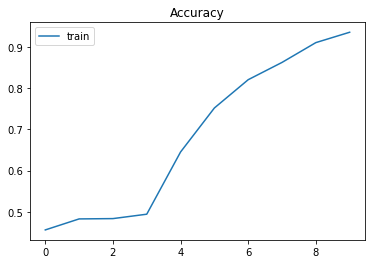

In [ ]:
plt.title('Accuracy')
plt.plot(history.history['accuracy'], label='train')
plt.legend()
plt.show();